In [1]:
import re
import collections
import operator
import time
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import numpy as np
import math

<div align='center'>
<h1>Inteligência Artificial</h1>
<h4>Universidade Federal de Sergipe<br>COMP0271 - 2018.1 - Unidade 03</h4>
<br>
<b> Professor </b> <br>
Hendrik Teixeira Macedo
<br><br>
<b> Alunos </b> <br/>
Demetrius Silva de Santana <br/>
Willis Vieira Santos Júnior
</div>

<h1 align="center">Redes de Crença Bayesianas</h1>

<h2 style="margin-bottom:0">Sumário</h2>
 
* Rede Bayesiana Escolhida
* Algoritmo Elimination-Ask
* Sistema Especialista
* Agente Especialista

## Rede Bayesiana Escolhida: Pathfinder
* Topologia da Rede
    * 135 nós
    * Tabela explícita de distribuição de probabilidade conjunta teria ~ 10^68 linhas
    * Próxima a uma poliárvore
    * Quantidade máxima de ancestrais de um nó: 7
* Aplicação da Rede
    * Diagnóstico de doenças linfonodais
    * Auxilia um patologista a diagnosticar amostras obtidas em biópsias

## Classes básicas para Redes Bayesianas (reuso)

In [3]:
from collections import defaultdict, Counter
import itertools
import math
import random

class BayesNet(object):
    "Bayesian network: a graph of variables connected by parent links."
     
    def __init__(self): 
        self.variables = [] # List of variables, in parent-first topological sort order
        self.lookup = {}    # Mapping of {variable_name: variable} pairs
            
    def add(self, name, parentnames, cpt):
        "Add a new Variable to the BayesNet. Parentnames must have been added previously."
        parents = [self.lookup[name] for name in parentnames]
        var = Variable(name, cpt, parents)
        self.variables.append(var)
        self.lookup[name] = var
        return self
    
class Variable(object):
    "A discrete random variable; conditional on zero or more parent Variables."
    
    def __init__(self, name, cpt, parents=()):
        "A variable has a name, list of parent variables, and a Conditional Probability Table."
        self.__name__ = name
        self.parents  = parents
        self.cpt      = CPTable(cpt, parents)
        self.domain   = set(itertools.chain(*self.cpt.values())) # All the outcomes in the CPT
                
    def __repr__(self): return self.__name__
    
class Factor(dict): "An {outcome: frequency} mapping."

class ProbDist(Factor):
    """A Probability Distribution is an {outcome: probability} mapping. 
    The values are normalized to sum to 1.
    ProbDist(0.75) is an abbreviation for ProbDist({T: 0.75, F: 0.25})."""
    def __init__(self, mapping=(), **kwargs):
        if isinstance(mapping, float):
            mapping = {T: mapping, F: 1 - mapping}
        self.update(mapping, **kwargs)
        normalize(self)
        
class Evidence(dict): 
    "A {variable: value} mapping, describing what we know for sure."
        
class CPTable(dict):
    "A mapping of {row: ProbDist, ...} where each row is a tuple of values of the parent variables."
    
    def __init__(self, mapping, parents=()):
        """Provides two shortcuts for writing a Conditional Probability Table. 
        With no parents, CPTable(dist) means CPTable({(): dist}).
        With one parent, CPTable({val: dist,...}) means CPTable({(val,): dist,...})."""
        if len(parents) == 0 and not (isinstance(mapping, dict) and set(mapping.keys()) == {()}):
            mapping = {(): mapping}
        for (row, dist) in mapping.items():
            if len(parents) == 1 and not isinstance(row, tuple): 
                row = (row,)
            self[row] = ProbDist(dist)

class Bool(int):
    "Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'"
    __str__ = __repr__ = lambda self: 'T' if self else 'F'
        
T = Bool(True)
F = Bool(False)

### Funções associadas (reuso)

In [4]:
def P(var, evidence={}):
    "The probability distribution for P(variable | evidence), when all parent variables are known (in evidence)."
    row = tuple(evidence[parent] for parent in var.parents)
    return var.cpt[row]

def normalize(dist):
    "Normalize a {key: value} distribution so values sum to 1.0. Mutates dist and returns it."
    total = sum(dist.values())
    for key in dist:
        dist[key] = dist[key] / total
        assert 0 <= dist[key] <= 1, "Probabilities must be between 0 and 1."
    return dist

def sample(probdist):
    "Randomly sample an outcome from a probability distribution."
    r = random.random() # r is a random point in the probability distribution
    c = 0.0             # c is the cumulative probability of outcomes seen so far
    for outcome in probdist:
        c += probdist[outcome]
        if r <= c:
            return outcome
        
def globalize(mapping):
    "Given a {name: value} mapping, export all the names to the `globals()` namespace."
    globals().update(mapping)
    
def printDist(dist, m=8, sort="prob", padding=50):
    c = 0
    s = sorted(dist.items(), key=lambda a: -a[1]) if sort=="prob" else sorted(dist.items(), key=lambda a: a[0])
    p = 1
    for e in s:
        print("{}: {}%".format(e[0].rjust(padding), format(100*e[1], '>5.2f')))
        p -= e[1]
        c += 1
        if (c == m-1) and (len(s) - c > 1):
            print("{}: {}%".format("---other---".rjust(padding), format(100*p, '>5.2f')))
            break

### Funções associadas
* Exibição da Rede Bayesiana
* Atualização de Tupla

In [5]:
def updateTuple(NamedTuple,nameOfNamedTuple,changes):
    ## Convert namedtuple to an ordered dictionary, which can be updated
    NamedTuple_asdict = NamedTuple._asdict()
    ## Make changes to the required named attributes
    for key in changes:
        NamedTuple_asdict[key]= changes[key]
    ## reconstruct the namedtuple using the updated ordered dictionary
    updated_NamedTuple = collections.namedtuple(nameOfNamedTuple, NamedTuple_asdict.keys())(**NamedTuple_asdict)
    return updated_NamedTuple

In [6]:
def plotBN(parser, q=[], e={}):
    xy = np.array([n.position for k, n in parser.nodes.items()])
    sizes = [10 + 30*n.childnum[0]**.5 for k, n in parser.nodes.items()]
    fig=plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    ax1 = fig.subplots()
    lines = []
    for name, node in parser.nodes.items():
        for p in node.parents:
            ax1.arrow(*parser.nodes[p].position, *(- np.array(parser.nodes[p].position) + np.array(node.position)), linewidth=.5, length_includes_head=True, color="blue", head_width=8)
    colors = ['red' if eval(n) in q else 'orange' if eval(n) in e else 'yellow' if eval(n) in ancestors(list(q) + list(e)) else 'black' for n, v in parser.nodes.items()]
    ax1.scatter(xy[:,0], xy[:,1], s=sizes, color=colors, zorder=2)
    plt.show()

In [7]:
class Storage:
    def __init__(self):
        self.dicts = {}
        self.indices = {}
    
    def set_dict(self, f, i):
        self.dicts[f.__name__] = {}
        self.indices[f.__name__] = i
    
    def lookup(self, f, *args):
        dd = self.dicts
        if f.__name__ not in dd:
            self.set_dict(f, -1)
        d = dd[f.__name__]
        i = self.indices[f.__name__]
        a = tuple(args) if i == -1 else tuple(args[i])
        if a not in d:
            d[a] = f(*args)
        return d[a]

In [8]:
store = Storage()

# Inferência com eliminação de variáveis

In [9]:
def elimination_ask(X, evidence, net):
    "The probability distribution for query variable X in a belief net, given evidence."
    def sort_key(v):
        return len(set([]).union(*[set(f.vars) for f in factors if v in f.vars]))
    relevant = ancestors(list(evidence) + [X])
    factors = {make_factor(v, evidence) for v in relevant}
    relevant = [v for v in relevant if v not in evidence and v != X]
    
    while len(relevant) > 0:
        relevant.sort(key = sort_key)
        v = relevant.pop()
        relevant_factors = []
        factors_ = factors.copy()
        for f in factors:
            if v in f.vars:
                relevant_factors.append(f)
                factors_.remove(f)
        factors = factors_
        factors.add(sum_out(v, pointwise_product_multi(*relevant_factors)))
    
    f = pointwise_product_multi(*factors)
    prob_dict = {v: f.tensor[i] for i, v in enumerate(ordered_domain(X))}
    try:
        return ProbDist(prob_dict)
    except:
        return None # evidência inválida

In [10]:
def ancestors(variables):
    an_vars = set([])
    if len(variables) == 0:
        return set([])
    for v in variables:
        an_vars |= store.lookup(ancestors, frozenset(v.parents))
    return an_vars | set(variables)

class Factor:
    def __init__(self, vv, tensor):
        self.vars = vv
        self.tensor = tensor

def ordered_domain(v):
    return list(list(v.cpt.items())[0][1].keys())

def make_factor(v, e):
    dim = []
    for p in v.parents:
        dim.append(len(p.domain))
    dim.append(len(v.domain))
    tensor = np.array([list(x.values()) for x in v.cpt.values()])
    tensor = np.reshape(tensor, dim)
    pp = v.parents.copy()
    pp.append(v)
    vv = pp.copy()
    count = 0
    for i, p in enumerate(pp):
        if p in e:
            od = ordered_domain(p)
            ncut = np.zeros(len(od))
            ncut[od.index(e[p])] = 1
            tensor = np.tensordot(ncut, tensor, axes = [[0], [i - count]])
            count += 1
            vv.remove(p)
    return Factor(vv, tensor)

def pointwise_product(fa, fb):
    vva, ta = fa.vars, fa.tensor
    vvb, tb = fb.vars, fb.tensor
    vvi = list(set(vva) & set(vvb))
    domains = {}
    dim = []
    vv = vvi.copy()
    for v in vvi:
        domains[v] = ordered_domain(v)
        dim.append(len(domains[v]))
    for v in vva:
        if v not in vv:
            dim.append(len(ordered_domain(v)))
            vv.append(v)
    for v in vvb:
        if v not in vv:
            dim.append(len(ordered_domain(v)))
            vv.append(v)
    t = []
    for x in itertools.product(*(domains.values())):
        s1 = [slice(None) if y not in vvi
                 else [domains[y].index(x[vvi.index(y)])]
                 for y in vva
                ]
        try:
            t1 = ta[s1]
        except:
            t1 = ta
        s2 = [slice(None) if y not in vvi
                 else [domains[y].index(x[vvi.index(y)])]
                 for y in vvb
                ]
        try:
            t2 = tb[s2]
        except:
            t2 = tb
        t.append(np.outer(t1, t2))
    tensor = np.reshape(np.concatenate(t), dim)
    return Factor(vv, tensor)

def pointwise_product_multi(*ff):
    s = ff[0]
    for f in ff[1:]:
        s = pointwise_product(s, f)
    return s

def sum_out(v, f):
    vv, t = f.vars.copy(), f.tensor
    t = np.sum(t, axis = vv.index(v))
    vv.remove(v)
    return Factor(vv, t)

# Importando dados da Rede Bayesiana
* A partir de arquivo no formato DSC
* Cria objeto da classe BayesNet
    * Obtém nós e CPTs do arquivo passado como parâmetro

In [11]:
Node = collections.namedtuple('Node', 'ord id name values position label category parents childnum')

class DSC_parser:
    def __init__(self, filename):
        self.input = open(filename, "r").read()
        self.nodes = {}
        self.cpts = {}
        self.BayesNet = BayesNet()
        self.jointDist = None

    def fetch_value(self, string, index):
        try:
            return re.search(index+r'[\s]*[:=][\s]*"?([^"]*?)"?[\s]*;', string, re.M|re.I|re.S).groups()[0]
        except:
            return None
    
    def create_prob_dist(self, values, probs):
        prob_dict = {}
        count = 0
        for v in values:
            prob_dict[v] = probs[count]
            count += 1
        return prob_dict
    
    def parse_nodes(self):
        node_str = re.findall(r'(node [^\{]*?\{[^\{]*?\{[^\}]*?\}[^\}]*?\})([\s]*?)', self.input, re.M|re.I|re.S)
        nodes = []
        count = 0
        for r in node_str:
            r = r[0]
            _id = re.search(r'node[\s]*([^\n\{\s]*)', r, re.M|re.I).groups()[0]
            name = self.fetch_value(r, 'name')
            values_str = re.search(r'[;\{][\s]*?(type[^\{]*?:[^\{]*?\{[^\}]*?\};)', r, re.M|re.I).groups()[0]
            values = re.findall(r'"([^"]*?)",?', values_str, re.M|re.I)
            try:
                position = eval(self.fetch_value(r, 'position'))
            except:
                position = None
            label = self.fetch_value(r, 'label')
            category = self.fetch_value(r, 'category')
            nodes.append(Node(count, _id, name, values, position, label, category, [], [0]))
            count += 1
        self.nodes = {n.id: n for n in nodes}
            
    def parse_probabilities(self):
        prob_str = re.findall(r'(probability[^\{]*?\{[^\}]*?\})([\s]*)', self.input, re.M|re.I|re.S)
        for r in prob_str:
            r = r[0]
            var_name = re.search(r'probability[\s]*\([\s]*([^\s\)]*)[\s]*', r, re.M|re.I).groups()[0]
            try:
                par_names = re.search(var_name+r'[\s]*\|[\s]*(.*?)[\s]*\)', r, re.M|re.I).groups()[0].split(',')
                par_names = [s.strip() for s in par_names]
                self.nodes[var_name] = updateTuple(self.nodes[var_name], "Node", {"parents": par_names})
                for p in par_names:
                    self.nodes[p].childnum[0] += 1
            except:
                par_names = []
            if (par_names):
                lines = re.findall(r'\([0-9, ]*?\)[^;]*;', r, re.M|re.I)
                cpt = {}
                for l in lines:
                    par_vals = eval(re.search(r'\([^\)]*?\)', l, re.M|re.I)[0])
                    new_par_vals = []
                    count = 0
                    if len(par_names) > 1:
                        for p in par_names:
                            new_par_vals.append(self.nodes[p].values[par_vals[count]])
                            count += 1
                    else:
                        new_par_vals.append(self.nodes[par_names[0]].values[par_vals])
                    par_vals = tuple(new_par_vals)
                    prob_vals = re.search(r':([^;]*?);', l, re.M|re.I).groups()[0].split(",")
                    prob_vals = [float(p.strip())/100 for p in prob_vals]
                    if sum(prob_vals) == 0:
                        prob_vals = [1/len(prob_vals) for p in prob_vals]
                    cpt[par_vals] = self.create_prob_dist(self.nodes[var_name].values, prob_vals)
                self.cpts[var_name] = cpt
            else:
                lines = re.findall(r'[0-9]+\.?[0-9]*', r, re.M|re.I)
                self.cpts[var_name] = {(): self.create_prob_dist(self.nodes[var_name].values, [float(l)/100 for l in lines])}
            
    def create_BayesNet(self):
        self.parse_nodes()
        self.parse_probabilities()
        assert len(self.nodes) == len(self.cpts)
        added_nodes = []
        sorted_nodes = [self.nodes[key] for key in self.nodes]
        node = sorted_nodes[0]
        self.BayesNet.add(node.id, node.parents, self.cpts[node.id])
        added_nodes.append(node.id)
        while len(added_nodes) != len(sorted_nodes):
            for node in sorted_nodes:
                if (not node.id in added_nodes) and (len([n for n in node.parents if n in added_nodes]) == len(node.parents)):
                    self.BayesNet.add(node.id, node.parents, self.cpts[node.id])
                    added_nodes.append(node.id)
        globalize(self.BayesNet.lookup)
        #self.jointDist = joint_distribution(self.BayesNet)
        

In [12]:
pathfinder_parser = DSC_parser("pf23.dsc")
pathfinder_parser.create_BayesNet()
pathfinder = pathfinder_parser.BayesNet

In [13]:
prod = 1
for x in [len(v.domain) for v in pathfinder.variables]:
    prod *= x
print(prod)

34050492048666535663554160091797969384243200000000000000000000000000


In [14]:
start_time = time.time()
result = elimination_ask(Fault,
                         {TAB: 'Absent',
                          PFP: 'Absent'},
                         pathfinder)
elapsed_time = time.time() - start_time
print(ancestors([Fault, TAB, PFP]))
print("\n======= Tempo da Query: {} s\n".format(elapsed_time))
printDist(result, padding=25)

{Fault, TAB, PFP}

======= Tempo da Query: 0.09306526184082031 s

       Small cleaved, fol: 11.24%
          Large cell, dif: 11.24%
     Nodular sclerosis HD:  8.73%
     Small noncleaved dif:  8.17%
     Mixed cellularity HD:  6.79%
               Mixed, fol:  5.62%
      Dermatopathic laden:  2.55%
              ---other---: 45.65%


In [15]:
start_time = time.time()
result = elimination_ask(ICLC,
                         {MA_NEUT: 'Present',
                          NEUTRO: 'Prominent',
                          HIV_ST: 'Negative'},
                         pathfinder)
elapsed_time = time.time() - start_time
print(ancestors([ICLC, MA_NEUT, NEUTRO, HIV_ST]))
print("\n======= Tempo da Query: {} s\n".format(elapsed_time))
printDist(result, padding=25)

{Fault, ICLC, LLC_I, LLC, MLC, HIV_ST, MLC_I, ECCC, NEUTRO, MA_NEUT}

======= Tempo da Query: 0.16711783409118652 s

                   Absent: 99.42%
                  Present:  0.58%


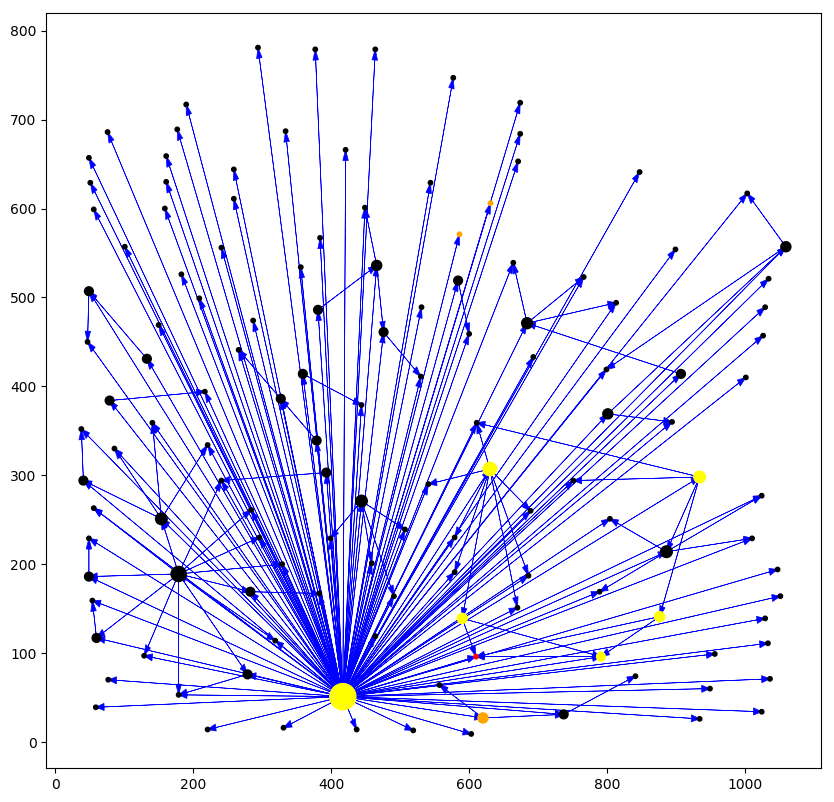

In [16]:
plotBN(pathfinder_parser,
       q={ICLC},
       e={MA_NEUT, NEUTRO, HIV_ST})

In [17]:
diabetes_parser = DSC_parser("diabetes.dsc")
diabetes_parser.create_BayesNet()
diabetes = diabetes_parser.BayesNet
start_time = time.time()
result = elimination_ask(cho_1,
                         {},
                         diabetes)
print(ancestors([cho_1]))
elapsed_time = time.time() - start_time
print("\n======= Tempo da Query: {} s\n".format(elapsed_time))
printDist(result, m=30, sort="prob", padding=25)

{meal_1, meal_0, cho_1, cho_bal_0, gut_abs_0, cho_init, cho_0}

======= Tempo da Query: 0.32022809982299805 s

               8_0mmol_kg: 84.63%
               7_6mmol_kg:  4.97%
               7_2mmol_kg:  1.63%
               6_0mmol_kg:  0.92%
               6_4mmol_kg:  0.82%
               5_6mmol_kg:  0.81%
               6_8mmol_kg:  0.81%
               4_4mmol_kg:  0.70%
               5_2mmol_kg:  0.66%
               4_8mmol_kg:  0.66%
               4_0mmol_kg:  0.61%
               3_6mmol_kg:  0.48%
               2_8mmol_kg:  0.47%
               3_2mmol_kg:  0.46%
               2_4mmol_kg:  0.39%
               2_0mmol_kg:  0.27%
               1_6mmol_kg:  0.23%
               1_2mmol_kg:  0.21%
               0_8mmol_kg:  0.13%
               0_4mmol_kg:  0.08%
               0_0mmol_kg:  0.07%


In [18]:
munin_parser = DSC_parser("munin.dsc")
munin_parser.create_BayesNet()
munin = munin_parser.BayesNet
start_time = time.time()
args = [R_LNLW_MED_SEV,
        {L_SUR_DSLOW_CA: "M_S08"},
        munin]
result = elimination_ask(*args)
print(ancestors([args[0]] + list(args[1])))
elapsed_time = time.time() - start_time
print("\n======= Tempo da Query: {} s\n".format(elapsed_time))
printDist(result, padding=25)

{DIFFN_S_SEV_DIST, DIFFN_PATHO, L_OTHER_ISCH_DIFSLOW, L_DIFFN_ISCH_DIFSLOW, L_SUR_DIFSLOW_CA, L_SUR_DSLOW_CA, DIFFN_TYPE, L_OTHER_ISCH_SALOSS, L_DIFFN_ISCH_SALOSS, L_LNL_ISCH_SEV, DIFFN_SEV, L_LNL_ISCH_PATHO, L_LNL_ISCH_SALOSS_CA, L_DIFFN_LNL_ISCH_SALOSS, L_SUR_SALOSS, DIFFN_SENS_SEV, R_LNLW_MED_SEV, DIFFN_DISTR}

======= Tempo da Query: 0.2972092628479004 s

                       NO: 89.50%
                     MILD:  6.00%
                      MOD:  3.00%
                      SEV:  1.00%
                    TOTAL:  0.50%


# Sistema Especialista

In [23]:
%matplotlib notebook
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets

bn = pathfinder
parser = pathfinder_parser
btn_query = widgets.Button(description="Query")
btn_belief = widgets.Button(description="Evidência / Crença")
btn_run = widgets.Button(description="Executar")
btn_clear = widgets.Button(description="Reiniciar")
btn_ok = widgets.Button(description="OK")
label = widgets.Label(value="", width=200)
output = widgets.Output(width=200)
vars_=[str(v) + ": " + parser.nodes[str(v)].name for v in bn.variables]
var_list = widgets.Select(
    options=[],
    #value='Fault',
    # rows=10,
    description='',
    disabled=False
)
output.layout.height="500px"
output.layout.overflow="scroll"
var_list.layout.width="500px"

def update_label():
    if query or len(belief) > 0:
        label.value = "P({} | {})".format(query, belief) if len(belief) > 0 else "P({})".format(query)
    else:
        label.value = ""

def on_query_clicked(b):
    global clicked
    clicked = b.description
    if clicked == "Query":
        var_list.description = 'Query:'
        var_list.options = vars_
    elif clicked == "Evidência / Crença":
        var_list.description = 'Evid. (Var):'
        var_list.options = vars_
    var_container.layout.visibility = 'visible'

def on_ok_clicked(b):
    global query, belief, v, clicked
    if clicked == "Query":
        query = re.search(r'([^:]*?):', var_list.value)[1]
        var_container.layout.visibility = 'hidden'
    elif clicked == "Evidência / Crença":
        clicked = "Observado"
        v = eval(re.search(r'([^:\s]*?):', var_list.value)[1])
        r = elimination_ask(v, belief, bn)
        var_list.description = str(v) + ":"
        var_list.options = ["{}: {}%".format(x, format(100*y, '.2f')) for x, y in r.items()]
    elif clicked == "Observado":
        o = re.search(r'([^:]*?):', var_list.value)[1]
        belief[v] = o
        var_container.layout.visibility = 'hidden'
    update_label()
    
def clear(b):
    global query, belief, clicked
    query = None
    belief = {}
    clicked = None
    update_label()
    output.clear_output()
    var_container.layout.visibility = 'hidden'
    
def run(b):
    global query, belief, clicked, bn
    start_time = time.time()
    result = elimination_ask(eval(query), belief, bn)
    elapsed_time = time.time() - start_time
    output.clear_output()
    with output:
        print("\n======= Tempo da Query: {} s\n".format(elapsed_time))
        print("Avaliando Query: {}\n\n".format(label.value))
        printDist(result)
    
btn_query.on_click(on_query_clicked)
btn_belief.on_click(on_query_clicked)
btn_ok.on_click(on_ok_clicked)
btn_run.on_click(run)
btn_clear.on_click(clear)
buttons_container = widgets.HBox()
var_container = widgets.HBox()
buttons_container.children = [btn_query, btn_belief, btn_run, btn_clear]
var_container.children = [var_list, btn_ok]
display(buttons_container)
display(label)
display(var_container)
display(output)
clear(None)
var_container.layout.visibility = 'hidden'

HBox(children=(Button(description='Query', style=ButtonStyle()), Button(description='Evidência / Crença', style=ButtonStyle()), Button(description='Executar', style=ButtonStyle()), Button(description='Reiniciar', style=ButtonStyle())))

Label(value='')

HBox(children=(Select(layout=Layout(width='500px'), options=(), value=None), Button(description='OK', style=ButtonStyle())))

Output(layout=Layout(height='500px', overflow='scroll'))

# Agente Especialista

In [20]:
class Environment():

    def __init__(self, bayes_network, unobservable, evidence_per_case = 3):
        self.bn = bayes_network
        self.unobservable = unobservable
        self.observable = list(set(self.bn.variables) - set(unobservable))
        self.reals = [] # list of dict
        self.cases = [] # list of dicts
        self.case_num = -1
        self.epd = evidence_per_case

    def random_case(self, num_evidences, new_case = True):
        if new_case:
            self.case_num += 1
            case = {}
            self.cases.append(case)
            for v in self.unobservable:
                real = {}
                real[v] = sample(elimination_ask(v, case.copy(), self.bn))
            self.reals.append(real)
        case = self.cases[self.case_num]
        real = self.reals[self.case_num]
        vv = list(set(self.observable) - set(case))
        random_indexes = random.sample(range(len(vv)), num_evidences)
        for p in random_indexes:
            self.reveal_variable(vv[p], case)
    
    def reveal_variable(self, variable, case):
        real = self.reals[self.cases.index(case)]
        case[variable] = sample(elimination_ask(variable, {**case, **real}, self.bn))

    def new_case(self):
        self.random_case(num_evidences = self.epd)
        return self.cases[self.case_num]
    
    def last_case(self):
        return self.cases[self.case_num]
    
    def last_real(self):
        return self.reals[self.case_num]

In [21]:
class Agent():
    
    def __init__(self, environment):
        self.environment = environment
        self.variables = environment.bn.variables
        self.unobservable = environment.unobservable
        self.nonEvidences = set(self.variables)
        self.results = [] # list of dicts
        self.case_num = -1

    def sensor(self):
        self.environment.new_case()
        self.case_num += 1
        result = {}
        self.results.append(result)
        
    def reason(self, query=[], full=False):
        result = self.results[self.case_num]
        case = self.environment.last_case()
        loop = self.nonEvidences if full else self.unobservable
        if len(query) == 0:
            loop = set(loop) - set(result) - set(case)
        else:
            loop = query
        for nonEvidence in loop:
            result[nonEvidence] = elimination_ask(nonEvidence, case, self.environment.bn)

    def request(self, vars_):
        case = env.cases[env.case_num]
        for v in vars_:
            env.reveal_variable(v, case)
        self.results[self.case_num] = {}
    
    def result(self, v):
        return (self.results[self.case_num])[v]
    
    def most_uncertain(self):
        result = self.results[self.case_num]
        minmax_p = {k: max(v.values()) for k, v in result.items() if k not in self.unobservable}
        minmax_p = list(minmax_p.items())
        minmax_p.sort(key=lambda a: a[1])
        return minmax_p
    
    def printQ(self, q):
        printDist(self.result(q))
        
    def printE(self):
        env = self.environment
        case = env.cases[env.case_num]
        for e, v in case.items():
            print("{} = {}".format(e, v))

# Agente Especialista explorando o ambiente

In [22]:
env = Environment(pathfinder, [Fault])
explorer = Agent(env)

out2 = widgets.Output()
out2.layout.height = "1000px"
btn_explore = widgets.Button(description="Explorar")
display(btn_explore)
display(out2)

def explore(b):
    out2.clear_output()
    with out2:
        print("Observando novo caso no ambiente...\n\n")
        explorer.sensor()
    explorer.reason([Fault])
    mu = [[None, 0]]
    while (max(explorer.result(Fault).values()) < .9) and (mu[0][1] < .8):
        explorer.reason([], full=True)
        out2.clear_output()
        with out2:
            print("Avaliando o caso encontrado...")
            print("Evidências acumuladas\n")
            explorer.printE()
            print("\n\nPossíveis diagnósticos\n")
            explorer.printQ(Fault)
            mu = explorer.most_uncertain()[0:3]
            print("\nMaiores incertezas:")
            for i, (k, v) in enumerate(mu):
                print("===>> max(P({} | evidence)) = {}%".format(k, format(100*v, '.2f')))
            print("Solicitando avaliação dessas variáveis...")
            time.sleep(1)
            explorer.request([x[0] for x in mu])
            explorer.reason([Fault])
    out2.clear_output()
    with out2:
        print("\n\nEvidências acumuladas\n")
        explorer.printE()
        r = list(explorer.result(Fault).items())
        r.sort(key=lambda a: -a[1])
        if r[0][1] > .9:
            print("\n\nProvável diagnóstico: Fault = {} ({}%)".format(r[0][0], format(100*r[0][1], '>5.2f')))
        else:
            print("\n\nPossível diagnóstico: Fault = {} ({}%)".format(r[0][0], format(100*r[0][1], '>5.2f')))
        print("\n\n(Realidade: Fault = {})".format(list(env.last_real().values())[0]))
        
btn_explore.on_click(explore)

Button(description='Explorar', style=ButtonStyle())

Output(layout=Layout(height='1000px'))